# MNIST Digit Classification - FCN

In [1]:
from __future__ import division, print_function
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch.autograd import Variable
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
TRAIN_FILE = os.path.join(DATA_DIR, "mnist_train.csv")
TEST_FILE = os.path.join(DATA_DIR, "mnist_test.csv")

MODEL_FILE = os.path.join(DATA_DIR, "torch-mnist-fcn-{:d}.model")

LEARNING_RATE = 0.001
INPUT_SIZE = 28*28
BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 10

## Prepare Data

In [3]:
def parse_file(filename):
    xdata, ydata = [], []
    fin = open(filename, "rb")
    i = 0
    for line in fin:
        if i % 10000 == 0:
            print("{:s}: {:d} lines read".format(
                os.path.basename(filename), i))
        cols = line.strip().split(",")
        ydata.append(int(cols[0]))
        xdata.append([float(x) / 255. for x in cols[1:]])
        i += 1
    fin.close()
    print("{:s}: {:d} lines read".format(os.path.basename(filename), i))
    X = np.array(xdata)
    y = np.array(ydata)
    return X, y

Xtrain, ytrain = parse_file(TRAIN_FILE)
Xtest, ytest = parse_file(TEST_FILE)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

mnist_train.csv: 0 lines read
mnist_train.csv: 10000 lines read
mnist_train.csv: 20000 lines read
mnist_train.csv: 30000 lines read
mnist_train.csv: 40000 lines read
mnist_train.csv: 50000 lines read
mnist_train.csv: 60000 lines read
mnist_test.csv: 0 lines read
mnist_test.csv: 10000 lines read
(60000, 784) (60000,) (10000, 784) (10000,)


In [4]:
def datagen(X, y, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES):
    ohe = OneHotEncoder(n_values=num_classes)
    while True:
        shuffled_indices = np.random.permutation(np.arange(len(y)))
        num_batches = len(y) // batch_size
        for bid in range(num_batches):
            batch_indices = shuffled_indices[bid*batch_size:(bid+1)*batch_size]
            Xbatch = np.zeros((batch_size, X.shape[1]))
            Ybatch = np.zeros((batch_size, num_classes))
            for i in range(batch_size):
                Xbatch[i] = X[batch_indices[i]]
                Ybatch[i] = ohe.fit_transform(y[batch_indices[i]]).todense()
            yield Xbatch, Ybatch

self_test_gen = datagen(Xtrain, ytrain)
Xbatch, Ybatch = self_test_gen.next()
print(Xbatch.shape, Ybatch.shape)

(128, 784) (128, 10)


## Define Network

In [5]:
model = torch.nn.Sequential(
    # 784 => 512
    torch.nn.Linear(INPUT_SIZE, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),
    # 512 => 256
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),
    # 256 => 10
    torch.nn.Linear(256, NUM_CLASSES),
    torch.nn.Softmax()
)

In [6]:
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train Network

In [7]:
def compute_accuracy(pred_var, true_var):
    ypred = np.argmax(pred_var.data.numpy(), axis=1)
    ytrue = np.argmax(true_var.data.numpy(), axis=1)
    return accuracy_score(ypred, ytrue)
    
history = []
train_gen = datagen(Xtrain, ytrain, BATCH_SIZE)
for epoch in range(NUM_EPOCHS):
    num_batches = len(Xtrain) // BATCH_SIZE
    total_loss, total_acc = 0., 0.
    for _ in range(num_batches):
        Xbatch, Ybatch = train_gen.next()
        # convert to Torch datatype
        Xbatch = Variable(torch.from_numpy(Xbatch).float())
        Ybatch = Variable(torch.from_numpy(Ybatch).float())
        # forward
        Ybatch_ = model(Xbatch)
        # compute loss
        loss = loss_fn(Ybatch_, Ybatch)
        # zero parameter gradients
        optimizer.zero_grad()
        loss.backward()
        total_loss += loss.data[0]
        total_acc += compute_accuracy(Ybatch_, Ybatch)
        optimizer.step()
    total_loss /= num_batches
    total_acc /= num_batches
    torch.save(model, MODEL_FILE.format(epoch+1))
    print("Epoch {:d}/{:d}: loss={:.3f}, accuracy={:.3f}".format(
            (epoch+1), NUM_EPOCHS, total_loss, total_acc))
    history.append((total_loss, total_acc))

Epoch 1/10: loss=0.014, accuracy=0.904
Epoch 2/10: loss=0.006, accuracy=0.960
Epoch 3/10: loss=0.004, accuracy=0.971
Epoch 4/10: loss=0.004, accuracy=0.977
Epoch 5/10: loss=0.003, accuracy=0.980
Epoch 6/10: loss=0.003, accuracy=0.982
Epoch 7/10: loss=0.002, accuracy=0.984
Epoch 8/10: loss=0.002, accuracy=0.986
Epoch 9/10: loss=0.002, accuracy=0.987
Epoch 10/10: loss=0.002, accuracy=0.987


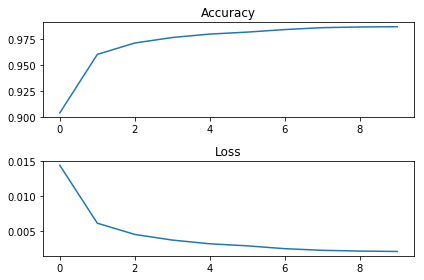

In [8]:
losses = [x[0] for x in history]
accs = [x[1] for x in history]

plt.subplot(211)
plt.title("Accuracy")
plt.plot(accs)

plt.subplot(212)
plt.title("Loss")
plt.plot(losses)

plt.tight_layout()
plt.show()

## Evaluate Network

In [9]:
BEST_MODEL_FILE = os.path.join(DATA_DIR, "torch-mnist-fcn-10.model")
model = torch.load(BEST_MODEL_FILE)

ys_, ys = [], []
test_gen = datagen(Xtest, ytest, BATCH_SIZE)
num_batches = len(Xtest) // BATCH_SIZE
for _ in range(num_batches):
    Xbatch, Ybatch = test_gen.next()
    Xbatch = Variable(torch.from_numpy(Xbatch).float())
    Ybatch = Variable(torch.from_numpy(Ybatch).float())
    Ybatch_ = model(Xbatch)
    ys_.extend(np.argmax(Ybatch_.data.numpy(), axis=1))
    ys.extend(np.argmax(Ybatch.data.numpy(), axis=1))

acc = accuracy_score(ys_, ys)
cm = confusion_matrix(ys_, ys)
print("Accuracy: {:.4f}".format(acc))
print("Confusion Matrix")
print(cm)

Accuracy: 0.9779
Confusion Matrix
[[ 969    1    5    0    1    3    5    2    6    2]
 [   1 1118    0    0    0    0    2    2    1    2]
 [   4    4 1018    6    7    1    1   13    4    3]
 [   0    2    3  997    0   17    1    3   11    5]
 [   1    0    1    0  959    1    3    0    1   12]
 [   0    0    0    1    0  860    3    0    3    2]
 [   2    2    1    0    3    3  938    0    0    1]
 [   1    1    2    3    1    2    0  996    2    6]
 [   1    4    2    3    3    4    3    6  941    8]
 [   0    0    0    0    4    1    1    3    2  967]]
